In [300]:
import pandas
pandas.set_option("display.max_rows", 50, "display.max_columns", 50)

import numpy
import pygsheets
import scipy.stats
import datetime

import matplotlib
import matplotlib.pyplot as mp
import seaborn

## colors

In [301]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

## import terminals data from sheet

In [302]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
spreadsheet = gc.open_by_key('1v38EY_kFFsT17cPqz39j21zRYWeQSSxuDmz565MD2GU')
#spreadsheet = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A2')

In [242]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# remove oil export terminals
terms_df_orig = terms_df_orig.loc[terms_df_orig['Fuel']!='Oil']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig['Wiki']!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig['Status']!='']

In [243]:
mtpa_multiplier = 1/0.7352941863 # multiply by this to convert to bcm
#euro_multiplier = 1/1.14 # multiply USD by this to get Euro, should be same as currency conversions in Sheet

In [244]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(terms_df_orig['Country'])))
region_list = sorted(list(set(terms_df_orig['Region'])))

## table for exports

In [245]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['Import/Export']=='Export')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['Import/Export']=='Export')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-export.xlsx')

mtpa_by_region_export_df = mtpa_by_region_df.copy()

mtpa_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,417.82,39.36,457.18,12.29,444.11,73.90,15.3,1.50,0.0
Eurasia,113.40,21.10,134.50,14.42,16.36,29.10,0.0,0.00,0.0
Sub-Saharan Africa,55.82,13.92,69.74,34.10,27.39,34.32,0.0,0.00,0.0
Middle East and North Africa,63.60,1.07,64.67,22.00,87.75,136.94,0.0,10.40,7.8
SE Asia,19.50,5.80,25.30,1.50,12.55,66.65,0.0,0.00,30.1
Australia and New Zealand,20.10,0.00,20.10,7.20,45.80,87.60,0.0,0.00,0.0
Latin America and the Caribbean,5.37,0.00,5.37,0.00,16.60,16.45,0.0,3.75,0.0
East Asia,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0
Europe,0.00,0.00,0.00,0.00,5.04,4.68,0.0,0.00,0.0
South Asia,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0


## table for imports

In [246]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['Import/Export']=='Import')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['Import/Export']=='Import')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
# drop all all-zero columns
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-import.xlsx')

mtpa_by_region_import_df = mtpa_by_region_df.copy()
mtpa_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,149.76,91.25,241.01,25.80,54.49,444.10,0.0,1.5,0.0
Europe,139.42,31.18,170.60,14.20,91.24,175.15,0.0,0.0,3.0
South Asia,68.00,33.00,101.00,5.68,80.95,65.20,0.0,0.0,0.0
SE Asia,78.55,21.66,100.21,11.10,28.34,45.05,0.0,0.0,0.0
Latin America and the Caribbean,43.48,12.28,55.76,6.46,16.07,53.36,0.0,0.0,0.0
Sub-Saharan Africa,6.88,1.70,8.58,0.50,7.70,0.11,0.0,0.0,0.0
Australia and New Zealand,3.30,1.90,5.20,0.00,1.75,0.00,0.0,0.0,0.0
Middle East and North Africa,5.15,0.00,5.15,11.10,18.64,48.90,11.8,0.0,0.0
North America,0.05,0.00,0.05,0.00,268.42,81.10,25.0,45.0,17.3
Eurasia,0.00,0.00,0.00,0.00,0.00,12.20,0.0,0.0,0.0


## stacked bar charts for import/export capacity

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_9845/1303677211.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')


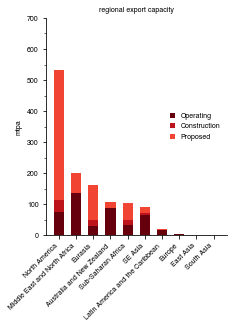

In [247]:
font_size = 7
ytop = 700
set_width=0.6

region_order = mtpa_by_region_export_df[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[1:]
use_this_df = mtpa_by_region_export_df.loc[region_order,:]

fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.bar(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', width=set_width)
ax.bar(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      bottom=use_this_df['Operating'], width=set_width)
ax.bar(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      bottom=use_this_df[['Operating','Construction']].sum(axis=1), width=set_width)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=font_size)
ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')
ax.set_ylabel('mtpa', size=font_size)

ax.set_ylim(0, ytop)
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

ax.set_title('regional export capacity', fontsize=font_size)

mp.savefig('saved-figures/regional-export-capacity.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/regional-export-capacity.pdf',
          bbox_inches='tight', 
          transparent=True)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_9845/3496407851.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')


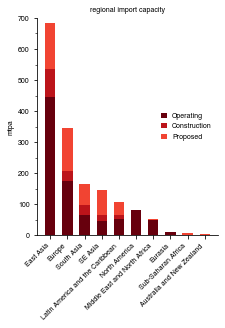

In [248]:
font_size = 7
ytop = 700
set_width=0.6

region_order = mtpa_by_region_import_df[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[1:]
use_this_df = mtpa_by_region_import_df.loc[region_order,:]

fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.bar(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', width=set_width)
ax.bar(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      bottom=use_this_df['Operating'], width=set_width)
ax.bar(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      bottom=use_this_df[['Operating','Construction']].sum(axis=1), width=set_width)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=font_size)
ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('mtpa', size=font_size)

ax.set_ylim(0, ytop)
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

ax.set_title('regional import capacity', fontsize=font_size)

mp.savefig('saved-figures/regional-import-capacity.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/regional-import-capacity.pdf',
          bbox_inches='tight', 
          transparent=True)

## export and import capacity over time

## import

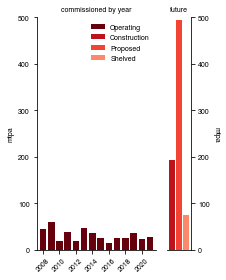

In [249]:
mtpa_started_sum = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['Import/Export']=='Import')&
                                     (terms_df_orig.Status=='Operating')].groupby('StartYearEarliest')['CapacityInMtpa'].sum()
#terms_df_orig.groupby('StartYearEarliest')['CapacityInMtpa'].sum()

# indev pipelines = Proposed or Construction
mtpa_indev = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['Import/Export']=='Import')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7

ytop = 500
ytop2 = 500

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(mtpa_started_sum.index.values[-15:-1], mtpa_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('mtpa', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, mtpa_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('mtpa', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-import-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-import-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

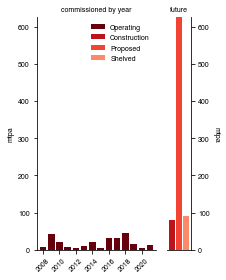

In [250]:
mtpa_started_sum = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['Import/Export']=='Export')&
                                     (terms_df_orig.Status=='Operating')].groupby('StartYearEarliest')['CapacityInMtpa'].sum()
#terms_df_orig.groupby('StartYearEarliest')['CapacityInMtpa'].sum()

# indev pipelines = Proposed or Construction
mtpa_indev = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['Import/Export']=='Export')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7

ytop = 625
ytop2 = 625

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(mtpa_started_sum.index.values[-15:-1], mtpa_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('mtpa', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, mtpa_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('mtpa', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-export-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

# redo fig above with big bars for each, not year-by-year

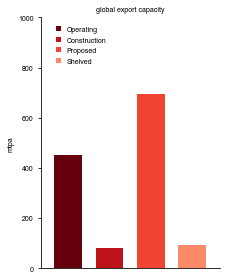

In [251]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                          (terms_df_orig['Import/Export']=='Export')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 1000
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('global export capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-export-summed-bars.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-summed-bars.pdf', bbox_inches='tight', transparent=True)

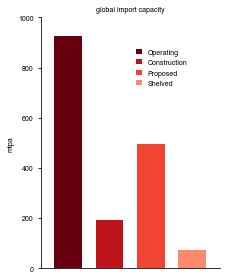

In [252]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                          (terms_df_orig['Import/Export']=='Import')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 1000
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.5,0.9))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('global import capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-import-summed-bars.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-import-summed-bars.pdf', bbox_inches='tight', transparent=True)

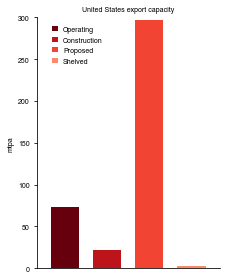

In [253]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                          (terms_df_orig['Import/Export']=='Export')&
                                          (terms_df_orig.Country=='United States')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 300
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('United States export capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-export-summed-bars-US-only.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-summed-bars-US-only.pdf', bbox_inches='tight', transparent=True)

# reproduce Clark Williams-Derry's plot

In [194]:
terms_df_cwd = terms_df_orig.loc[terms_df_orig.ExportFigureClarkWilliamsDerry=='yes']

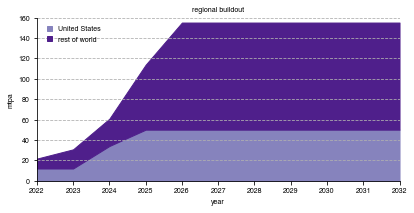

In [254]:
# fill up new capacities as they come online
start_year = 2022
end_year = 2032
year_list = range(start_year, end_year+1, 1)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_usa = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_cwd_subset = terms_df_cwd.loc[(terms_df_cwd.StartYearEarliest==year_list[yr_idx])]
    mtpa_sum[yr_idx:] += terms_df_cwd_subset['CapacityInMtpa'].sum()
    
    terms_df_cwd_subset_usa = terms_df_cwd.loc[(terms_df_cwd.StartYearEarliest==year_list[yr_idx])&
                                           (terms_df_cwd.Country=='United States')]
    mtpa_sum_usa[yr_idx:] += terms_df_cwd_subset_usa['CapacityInMtpa'].sum()

font_size = 7
fig = mp.figure(figsize=(6.5,3))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,160)

sel_cmap = matplotlib.cm.get_cmap('Purples')
color_light = sel_cmap(0.6)
color_dark = sel_cmap(0.9)
ax.fill_between(year_list, mtpa_sum_usa, 0, label='United States', color=color_light)
ax.fill_between(year_list, mtpa_sum, mtpa_sum_usa, label='rest of world', color=color_dark)

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.set_title('regional buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

mp.savefig('saved-figures/mtpa-export-usa-non-usa-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-usa-non-usa-timeseries.pdf', bbox_inches='tight', transparent=True)

## color coordinate by region

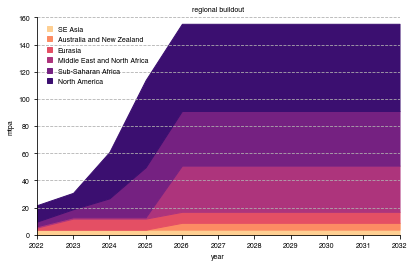

In [255]:
# fill up new capacities as they come online
start_year = 2022
end_year = 2032
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=region_list, index=year_list)

for yr_idx in range(year_list.__len__()):
    terms_df_cwd_subset = terms_df_cwd.loc[terms_df_cwd.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_cwd_subset.groupby('Region')['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

font_size = 7
fig = mp.figure(figsize=(6.5,4))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,160)

new_region_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.9,0.2,new_region_list.__len__())]

for region_idx in range(new_region_list.__len__()):
    if region_idx==0:
        ax.fill_between(year_list, mtpa_sum_regional_cumsum_byregion[region_list[region_idx]],
                        0, color=region_colors[region_idx], label=new_region_list[region_idx])
    else:
        ax.fill_between(year_list, mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx]],
                        mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx-1]], 
                        color=region_colors[region_idx], label=new_region_list[region_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.set_title('regional buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

mp.savefig('saved-figures/mtpa-export-regional-timeseries-CWD.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-regional-timeseries-CWD.pdf', bbox_inches='tight', transparent=True)

# our version of Clark Williams-Derry's plot (using Rob's column)

In [256]:
terms_df_cwd2 = terms_df_orig.loc[terms_df_orig.Construction_Sanctioned_July_2022=='yes']

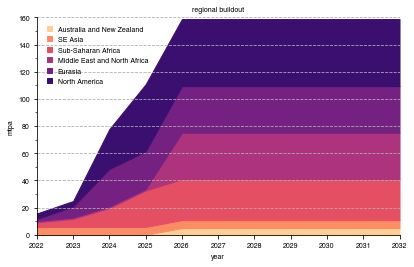

In [257]:
# fill up new capacities as they come online
start_year = 2022
end_year = 2032
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=region_list, index=year_list)

for yr_idx in range(year_list.__len__()):
    terms_df_cwd2_subset = terms_df_cwd2.loc[terms_df_cwd2.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_cwd2_subset.groupby('Region')['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

font_size = 7
fig = mp.figure(figsize=(6.5,4))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,160)

new_region_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.9,0.2,new_region_list.__len__())]

for region_idx in range(new_region_list.__len__()):
    if region_idx==0:
        ax.fill_between(year_list, mtpa_sum_regional_cumsum_byregion[region_list[region_idx]],
                        0, color=region_colors[region_idx], label=new_region_list[region_idx])
    else:
        ax.fill_between(year_list, mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx]],
                        mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx-1]], 
                        color=region_colors[region_idx], label=new_region_list[region_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.set_title('regional buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/mtpa-export-regional-timeseries-Construction_Sanctioned_July_2022.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-regional-timeseries-Construction_Sanctioned_July_2022.pdf', bbox_inches='tight', transparent=True)

# cost calculations

## create offshore and floating dfs

In [258]:
# insane outliers
# Ravenna - T068300
# Gorgon LNG (megaproject) - T068300
# Tanzania LNG Terminal trains 1, 2 - T026301, T026302
# Coral South FLNG Terminal - includes deep gas well construction - T025801
outlier_comboids = ['T068300','T068300','T026301','T026302','T025801']

In [259]:
terms_df_floating = terms_df_orig.loc[terms_df_orig.Floating=='yes']
terms_df_onshore = terms_df_orig.loc[terms_df_orig.Floating=='']

#terms_df_floating = terms_df_floating.loc[~terms_df_floating.ComboID.isin(outlier_comboids)]
#terms_df_onshore = terms_df_onshore.loc[~terms_df_onshore.ComboID.isin(outlier_comboids)]
terms_df_floating = terms_df_floating.loc[terms_df_floating.CostUSDPerMtpa<1e9]
terms_df_onshore = terms_df_onshore.loc[terms_df_onshore.CostUSDPerMtpa<1e9]

In [260]:
terms_df_floating_noexpansions = terms_df_floating.loc[~terms_df_floating['UnitName'].str.contains('Expansion')].drop_duplicates(subset=['TerminalName'], keep='first')
terms_df_onshore_noexpansions = terms_df_onshore.loc[~terms_df_onshore['UnitName'].str.contains('Expansion')].drop_duplicates(subset=['TerminalName'], keep='first')

## count for Scott - how many per region do we currently have?

## import

In [261]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Tema FSRU,Ghana,Construction,https://www.gem.wiki/Tema_FSRU,205882352.900000
Coega FSRU,South Africa,Proposed,https://www.gem.wiki/Coega_FSRU,500000000.000000
Kutubdia (Reliance) FSRU,Bangladesh,Cancelled,https://www.gem.wiki/Kutubdia_(Reliance)_FSRU,84444444.300000
Moheshkhali FLNG Terminal (Petrobangla),Bangladesh,Operating,https://www.gem.wiki/Moheshkhali_FLNG_Terminal_(Petrobangla),47236842.100000
Jawa Satu FSRU,Indonesia,Operating,https://www.gem.wiki/Jawa_Satu_FSRU,145833333.300000
Newcastle FSRU,Australia,Proposed,https://www.gem.wiki/Newcastle_FSRU,406410000.000000
Eagle FLNG Terminal,Albania,Cancelled,https://www.gem.wiki/Eagle_FLNG_Terminal,140740740.700000
Krk FSRU,Croatia,Operating,https://www.gem.wiki/Krk_FSRU,124887381.400000
Cyprus LNG Terminal,Cyprus,Construction,https://www.gem.wiki/Cyprus_LNG_Terminal,592800000.000000
Wilhelmshaven FSRU,Germany,Construction,https://www.gem.wiki/Wilhelmshaven_FSRU,93023991.300000


In [262]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Jorf Lasfar LNG Terminal,Morocco,Proposed,https://www.gem.wiki/Jorf_Lasfar_LNG_Terminal,874285632.700000
Kutubdia LNG Terminal (Petronet),Bangladesh,Cancelled,https://www.gem.wiki/Kutubdia_LNG_Terrminal_(Petronet),84444444.400000
Lahad Datu Sabah LNG Terminal,Malaysia,Cancelled,https://www.gem.wiki/Lahad_Datu_Sabah_LNG_Terminal,317105263.200000
Pengerang Johor LNG Terminal,Malaysia,Operating,https://www.gem.wiki/Pengerang_Johur_LNG_Terminal,169714285.700000
Gwadar LNG Terminal,Pakistan,Proposed,https://www.gem.wiki/Gwadar_LNG_Terminal,630136986.300000
Singapore LNG Terminal,Singapore,Operating,https://www.gem.wiki/Singapore_LNG_Terminal,154545454.500000
Boryeong LNG Terminal,South Korea,Operating,https://www.gem.wiki/Boryeong_LNG_Terminal,144210000.000000
Samcheok LNG Terminal,South Korea,Operating,https://www.gem.wiki/Samcheok_LNG_Terminal,132222222.200000
Kerewalapitiya LNG Terminal,Sri Lanka,Shelved,https://www.gem.wiki/Kerewalapitiya_LNG_Terminal,92592592.600000
Taichung LNG Terminal,Taiwan,Operating,https://www.gem.wiki/Taichung_LNG_Terminal,357000000.000000


## export

In [263]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Delfin FLNG Terminal,United States,Proposed,https://www.gem.wiki/Delfin_FLNG_Terminal,583333333.300000
Cameroon FLNG Terminal,Cameroon,Operating,https://www.gem.wiki/Cameroon_FLNG_Terminal,500000000.000000
Fortuna FLNG Terminal,Equatorial Guinea,Cancelled,https://www.gem.wiki/Fortuna_FLNG_Terminal,793650793.700000
Cedar FLNG Terminal,Canada,Proposed,https://www.gem.wiki/Cedar_FLNG_Terminal,800000000.000000
Gorskaya FLNG Terminal,Russia,Cancelled,https://www.gem.wiki/Gorskaya_FLNG_Terminal,248642857.100000
Greater Tortue Ahmeyim FLNG Terminal,Mauritania,Construction,https://www.gem.wiki/Greater_Tortue_Ahmeyim_FLNG,463680000.000000
Etinde FLNG Terminal,Cameroon,Proposed,https://www.gem.wiki/Etinde_FLNG_Terminal,384615384.600000
Ksi Lisims FLNG Terminal,Canada,Proposed,https://www.gem.wiki/Ksi_Lisims_FLNG_Terminal,833333333.300000
New Fortress Grand Isle FLNG Terminal,United States,Proposed,https://www.gem.wiki/New_Fortress_Grand_Isle_FLNG_Terminal,500000000.000000


In [264]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Commonwealth LNG Terminal,United States,Proposed,https://www.gem.wiki/Commonwealth_LNG_Terminal,571428571.400000
Eagle LNG Terminal,United States,Proposed,https://www.gem.wiki/Eagle_LNG_Terminal,547474747.500000
G2 LNG Terminal,United States,Proposed,https://www.gem.wiki/G2_LNG_Terminal,846153846.200000
Golden Pass LNG Terminal,United States,Construction,https://www.gem.wiki/Golden_Pass_LNG,552486187.800000
Gulf LNG Terminal,United States,Proposed,https://www.gem.wiki/Gulf_LNG,736648250.500000
Port Arthur LNG Terminal,United States,Proposed,https://www.gem.wiki/Point_Arthur_LNG_Terminal,62962963.000000
Egyptian LNG Terminal,Egypt,Operating,https://www.gem.wiki/ELNG_IDCO_Terminal,311111111.100000
Punta Europa LNG Terminal,Equatorial Guinea,Operating,https://www.gem.wiki/Punta_Europa_LNG_Terminal,405405405.400000
Mozambique LNG Terminal,Mozambique,Shelved,https://www.gem.wiki/Mozambique_LNG_Terminal,775193798.400000
Nigeria LNG Terminal,Nigeria,Construction,https://www.gem.wiki/Nigeria_LNG_Terminal,855263157.900000


### make dataframe to use for terminal calculations

* regional averages for onshore terminals
  * fewer than 3 data points, then apply a global value rather than a regional one!
* global averages for offshore terminals

In [265]:
onshore_export_regional_costs = pandas.DataFrame(index=region_list)

onshore_export_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_export_regional_costs.loc[(onshore_export_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values[0]
onshore_export_regional_costs

,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,4.0,5.949954e+08
East Asia,NaN,5.762813e+08
Eurasia,1.0,5.762813e+08
Europe,NaN,5.762813e+08
Latin America and the Caribbean,3.0,5.239181e+08
Middle East and North Africa,6.0,5.447671e+08
North America,11.0,5.404939e+08
SE Asia,1.0,5.762813e+08
South Asia,NaN,5.762813e+08
Sub-Saharan Africa,5.0,6.235952e+08


In [266]:
onshore_import_regional_costs = pandas.DataFrame(index=region_list)

onshore_import_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_import_regional_costs.loc[(onshore_import_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values[0]
onshore_import_regional_costs

,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,1.0,2.696893e+08
East Asia,15.0,3.516386e+08
Eurasia,NaN,2.696893e+08
Europe,15.0,2.325106e+08
Latin America and the Caribbean,4.0,3.104855e+08
Middle East and North Africa,2.0,2.696893e+08
North America,2.0,2.696893e+08
SE Asia,11.0,1.851841e+08
South Asia,5.0,2.557763e+08
Sub-Saharan Africa,NaN,2.696893e+08


In [267]:
floating_export_regional_costs = pandas.DataFrame(index=region_list)

floating_export_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_export_regional_costs.loc[:,
                                #(floating_export_regional_costs.NumberOfDataPoints<3) | 
                                #  (floating_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values[0]
floating_export_regional_costs

,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,NaN,5.674729e+08
East Asia,NaN,5.674729e+08
Eurasia,1.0,5.674729e+08
Europe,NaN,5.674729e+08
Latin America and the Caribbean,NaN,5.674729e+08
Middle East and North Africa,NaN,5.674729e+08
North America,4.0,5.674729e+08
SE Asia,NaN,5.674729e+08
South Asia,NaN,5.674729e+08
Sub-Saharan Africa,4.0,5.674729e+08


In [268]:
floating_import_regional_costs = pandas.DataFrame(index=region_list)

floating_import_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_import_regional_costs.loc[:,
                                   #(floating_import_regional_costs.NumberOfDataPoints<3) | 
                                  #(floating_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values[0]
floating_import_regional_costs

,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,3.0,1.376477e+08
East Asia,NaN,1.376477e+08
Eurasia,NaN,1.376477e+08
Europe,14.0,1.376477e+08
Latin America and the Caribbean,3.0,1.376477e+08
Middle East and North Africa,NaN,1.376477e+08
North America,NaN,1.376477e+08
SE Asia,4.0,1.376477e+08
South Asia,8.0,1.376477e+08
Sub-Saharan Africa,2.0,1.376477e+08


### global calculations

In [269]:
cost_onshore_export = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values
cost_onshore_export_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].std().values

cost_floating_export = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values
cost_floating_export_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].std().values

cost_onshore_import = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values
cost_onshore_import_error = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].std().values

cost_floating_import = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values
cost_floating_import_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].std().values

In [270]:
cost_onshore_export

array([5.76281271e+08])

In [271]:
cost_floating_export

array([5.67472856e+08])

In [272]:
cost_onshore_import

array([2.69689349e+08])

In [273]:
cost_floating_import

array([1.3764766e+08])

## now calculate the import terminal costs

## calculate how much export/import capacity data we have

In [274]:
terms_df_costs_exist = terms_df_orig.loc[~terms_df_orig.CostUSDPerMtpa.isnull()]
terms_df_costs_exist.to_excel('available-cost-data.xlsx', index=False)

In [275]:
#% of import terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Import')].shape)
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Import')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(510/587 * 100)

(607, 76)
(516, 76)
86.88245315161839


In [276]:
#% of export terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Export')].shape)
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Export')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(542/560 * 100)

(567, 76)
(548, 76)
96.78571428571429


In [277]:
floating_import_regional_costs.loc['Australia and New Zealand','RegionalCostUSDPerMtpa']

137647660.13235292

In [278]:
terms_df_import = terms_df_orig.loc[terms_df_orig['Import/Export']=='Import']

terms_df_import['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    floating_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    onshore_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_import['CostEstUSD'].isna()
terms_df_import.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_import[costs_exist_TF]['CostEstUSD']

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_9845/2744612308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_import['CostUSDTotal'] = numpy.nan
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## and calculate export terminal costs

In [279]:
terms_df_export = terms_df_orig.loc[terms_df_orig['Import/Export']=='Export']

terms_df_export['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    floating_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    onshore_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_export['CostEstUSD'].isna()
terms_df_export.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_export[costs_exist_TF]['CostEstUSD']

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_9845/498498827.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_export['CostUSDTotal'] = numpy.nan


## import terminal costs table

In [280]:
#mtpa by country
cost_by_country_import_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_import_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Country')['CostUSDTotal'].sum()

for status in status_list:
    #print(status)
    cost_by_region_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Region')['CostUSDTotal'].sum()

cost_by_country_import_df = cost_by_country_import_df.fillna(0)
cost_by_region_import_df = cost_by_region_import_df.fillna(0)

# add total and proposed+construction info
cost_by_region_import_df['Proposed+Construction'] = cost_by_region_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_import_df = cost_by_region_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_import_df['Proposed+Construction'] = cost_by_country_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_import_df = cost_by_country_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_import_df.index:
    cost_by_region_import_df.drop(index='Total', inplace=True)   
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

else:
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

# total
if 'Total' in cost_by_country_import_df.index:
    cost_by_country_import_df.drop(index='Total', inplace=True)   
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

else:
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

# save countries
cost_by_country_import_df = cost_by_country_import_df.loc[~(cost_by_country_import_df==0).all(axis=1)]
cost_by_country_import_df.to_excel('cost-by-country-import.xlsx')

cost_by_region_import_df/1e9

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,49.999150,31.296423,81.295573,7.144935,18.518813,154.534518,0.000000,0.527458,0.000000
Europe,26.259428,3.561384,29.820813,3.129799,18.624343,39.695091,0.000000,0.000000,0.412943
SE Asia,18.148108,2.733742,20.881850,3.698259,7.215494,6.982052,0.000000,0.000000,0.000000
South Asia,11.548361,6.539450,18.087811,0.924543,15.682637,14.250795,0.000000,0.000000,0.000000
Latin America and the Caribbean,4.636187,1.690313,6.326500,0.889204,4.384569,8.812590,0.000000,0.000000,0.000000
Middle East and North Africa,4.500000,0.000000,4.500000,1.527889,5.027009,8.571677,1.624242,0.000000,0.000000
Sub-Saharan Africa,3.177601,0.350000,3.527601,0.068824,1.059887,0.015141,0.000000,0.000000,0.000000
Australia and New Zealand,0.716910,0.172500,0.889410,0.000000,0.172500,0.000000,0.000000,0.000000,0.000000
North America,0.013484,0.000000,0.013484,0.000000,64.828924,20.459890,6.346109,12.136021,4.665626
Eurasia,0.000000,0.000000,0.000000,0.000000,0.000000,2.933697,0.000000,0.000000,0.000000


In [281]:
#mtpa by country
cost_by_country_export_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_export_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Country')['CostUSDTotal'].sum()

for status in status_list:
    #print(status)
    cost_by_region_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Region')['CostUSDTotal'].sum()

cost_by_country_export_df = cost_by_country_export_df.fillna(0)
cost_by_region_export_df = cost_by_region_export_df.fillna(0)

# add total and proposed+construction info
cost_by_region_export_df['Proposed+Construction'] = cost_by_region_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_export_df = cost_by_region_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_export_df['Proposed+Construction'] = cost_by_country_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_export_df = cost_by_country_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_export_df.index:
    cost_by_region_export_df.drop(index='Total', inplace=True)   
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

else:
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

# total
if 'Total' in cost_by_country_export_df.index:
    cost_by_country_export_df.drop(index='Total', inplace=True)   
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

else:
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

# save countries
cost_by_country_export_df = cost_by_country_export_df.loc[~(cost_by_country_export_df==0).all(axis=1)]
cost_by_country_export_df.to_excel('cost-by-country-export.xlsx')

cost_by_region_export_df/1e9

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,281.606032,29.929391,311.535423,11.140511,242.633047,39.942500,8.269557,0.810741,0.000000
Eurasia,69.682418,19.964422,89.646840,14.903063,11.516806,16.769785,0.000000,0.000000,0.000000
Sub-Saharan Africa,73.680642,15.001305,88.681947,24.680967,17.401679,26.993814,0.000000,0.000000,0.000000
Middle East and North Africa,54.317129,0.582901,54.900029,11.984877,58.593035,68.074428,0.000000,5.665578,4.249184
SE Asia,36.518331,2.352563,38.870894,0.864422,11.992932,54.969929,0.000000,0.000000,17.346066
Australia and New Zealand,28.301483,0.000000,28.301483,17.250000,30.920755,176.846423,0.000000,0.000000,0.000000
Latin America and the Caribbean,10.000000,0.000000,10.000000,0.000000,8.740743,6.481188,0.000000,0.974175,0.000000
East Asia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Europe,0.000000,0.000000,0.000000,0.000000,6.000000,6.176615,0.000000,0.000000,0.000000
South Asia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## costs of CWD/our version projects projects

In [292]:
terms_df_import.loc[terms_df_import.Construction_Sanctioned_July_2022=='yes']['CostUSDTotal'].sum()/1e9

0.0

In [293]:
terms_df_export.loc[terms_df_export.Construction_Sanctioned_July_2022=='yes']['CostUSDTotal'].sum()/1e9

142.48847601045225

In [299]:
terms_df_export.loc[terms_df_export.Construction_Sanctioned_July_2022=='yes'][['TerminalName','UnitName','CapacityInMtpa','Wiki','Import/Export','CostEstUSD','CostUSDTotal']]

,TerminalName,UnitName,CapacityInMtpa,Wiki,Import/Export,CostEstUSD,CostUSDTotal
26,Calcasieu Pass LNG Terminal,T13,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.621309e+08
27,Calcasieu Pass LNG Terminal,T14,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.621309e+08
28,Calcasieu Pass LNG Terminal,T15,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.621309e+08
29,Calcasieu Pass LNG Terminal,T16,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.621309e+08
30,Calcasieu Pass LNG Terminal,T17,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.621309e+08
31,Calcasieu Pass LNG Terminal,T18,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.621309e+08
100,Golden Pass LNG Terminal,T1,6.03,https://www.gem.wiki/Golden_Pass_LNG,Export,3.333333e+09,3.333333e+09
101,Golden Pass LNG Terminal,T2,6.03,https://www.gem.wiki/Golden_Pass_LNG,Export,3.333333e+09,3.333333e+09
102,Golden Pass LNG Terminal,T3,6.03,https://www.gem.wiki/Golden_Pass_LNG,Export,3.333333e+09,3.333333e+09
152,Plaquemines LNG Terminal,Phase 1 (Trains 1–18),10.00,https://www.gem.wiki/Venture_Global_Plaquemine...,Export,1.320000e+10,1.320000e+10


# pie charts with costs, mtpa

## import

In [285]:
cost_by_region_import_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,4.999915e+10,3.129642e+10,8.129557e+10,7.144935e+09,1.851881e+10,1.545345e+11,0.000000e+00,5.274579e+08,0.000000e+00
Europe,2.625943e+10,3.561384e+09,2.982081e+10,3.129799e+09,1.862434e+10,3.969509e+10,0.000000e+00,0.000000e+00,4.129430e+08
SE Asia,1.814811e+10,2.733742e+09,2.088185e+10,3.698259e+09,7.215494e+09,6.982052e+09,0.000000e+00,0.000000e+00,0.000000e+00
South Asia,1.154836e+10,6.539450e+09,1.808781e+10,9.245434e+08,1.568264e+10,1.425079e+10,0.000000e+00,0.000000e+00,0.000000e+00
Latin America and the Caribbean,4.636187e+09,1.690313e+09,6.326500e+09,8.892039e+08,4.384569e+09,8.812590e+09,0.000000e+00,0.000000e+00,0.000000e+00
Middle East and North Africa,4.500000e+09,0.000000e+00,4.500000e+09,1.527889e+09,5.027009e+09,8.571677e+09,1.624242e+09,0.000000e+00,0.000000e+00
Sub-Saharan Africa,3.177601e+09,3.500000e+08,3.527601e+09,6.882383e+07,1.059887e+09,1.514124e+07,0.000000e+00,0.000000e+00,0.000000e+00
Australia and New Zealand,7.169100e+08,1.725000e+08,8.894100e+08,0.000000e+00,1.725000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
North America,1.348447e+07,0.000000e+00,1.348447e+07,0.000000e+00,6.482892e+10,2.045989e+10,6.346109e+09,1.213602e+10,4.665626e+09
Eurasia,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.933697e+09,0.000000e+00,0.000000e+00,0.000000e+00


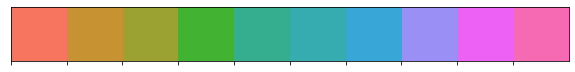

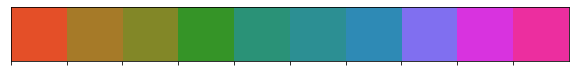

In [286]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, h=0.05, s=0.9, l=0.65))
seaborn.palplot(seaborn.husl_palette(10, h=0.05, l=0.55))

cmap_light = seaborn.husl_palette(10, h=0.05, l=0.6, s=0.9, as_cmap=True)
cmap_dark = seaborn.husl_palette(10, h=0.05, l=0.4, as_cmap=True)

##### mtpa_by_region_import_df

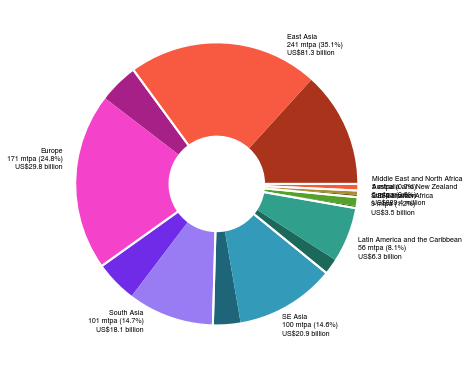

In [287]:
font_size=7

fig = mp.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(111)

nwedges = 8 # 8 nonzero rows #region_list.__len__()
region_order = mtpa_by_region_import_df.index[:nwedges]
pie_vals = mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].values

pie_labels = mtpa_by_region_import_df.index
pie_labels_mtpa = mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
pie_labels_perc = (mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'] / 
                   mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
pie_labels_cost = cost_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************
pie_vals_separated = mtpa_by_region_import_df.loc[region_order][['Construction','Proposed']].values.flatten()

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(1,0,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(1,0,nwedges))

pie_labels = [i+j+k+l for i,j,k,l in zip(pie_labels, pie_labels_mtpa, pie_labels_perc, pie_labels_cost)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_dark_10, cmap_light_10)).reshape(2*nwedges,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/mtpa-import-pie-graph-region-switch-dark-light.pdf', bbox_inches='tight', transparent=True)

mp.savefig('saved-figures/mtpa-import-pie-graph-region-switch-dark-light.png', 
           bbox_inches='tight', 
           transparent=True,
           dpi=600)

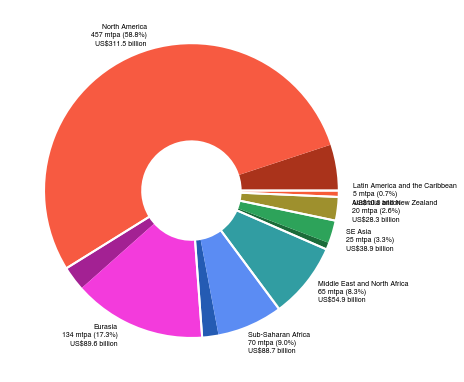

In [288]:
font_size=7

fig = mp.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(111)

nwedges = 7 # 8 nonzero rows #region_list.__len__()
region_order = mtpa_by_region_export_df.index[:nwedges]

pie_vals = mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].values
pie_labels = mtpa_by_region_export_df.index
pie_labels_mtpa = mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
pie_labels_perc = (mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'] / 
                   mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
pie_labels_cost = cost_by_region_export_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************
pie_vals_separated = mtpa_by_region_export_df.loc[region_order][['Construction','Proposed']].values.flatten()

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(1,0,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(1,0,nwedges))

pie_labels = [i+j+k+l for i,j,k,l in zip(pie_labels, pie_labels_mtpa, pie_labels_perc, pie_labels_cost)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_dark_10, cmap_light_10)).reshape(2*nwedges,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})

ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/mtpa-export-pie-graph-region-switch-dark-light.pdf', bbox_inches='tight', transparent=True)

mp.savefig('saved-figures/mtpa-export-pie-graph-region-switch-dark-light.png', 
           bbox_inches='tight', 
           transparent=True,
           dpi=600)

## big panel figure

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_9845/3628441242.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(region_order, rotation=45, ha='right', va='top')
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_9845/3628441242.py:141: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(region_order, rotation=45, ha='right', va='top')


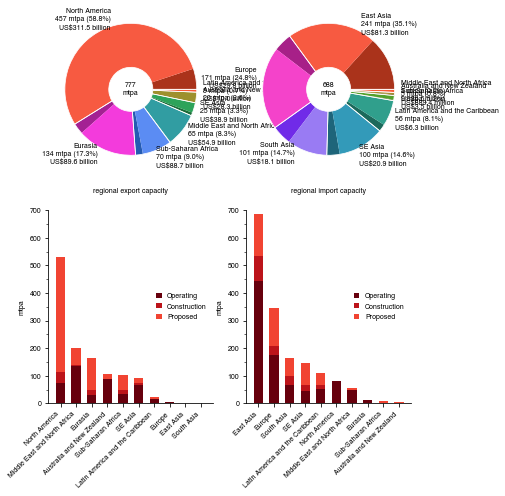

In [289]:
font_size=7
ytop = 700
set_width=0.6
pie_chart_line_width=0.75

fig = mp.figure(figsize=(6.5,8))#, constrained_layout=True)
widths = [1,1]
heights = [1.25,1]
gs = matplotlib.gridspec.GridSpec(nrows=2, ncols=2, figure=fig,
                                 wspace=0.2, hspace=0,
                                 width_ratios=widths,
                                 height_ratios=heights)

################################################################## TOP LEFT
ax1 = fig.add_subplot(gs[0,0])

nwedges = 7 # 8 nonzero rows #region_list.__len__()
region_order = mtpa_by_region_export_df.index[:nwedges]

pie_vals = mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].values
pie_labels = mtpa_by_region_export_df.index
pie_labels_mtpa = mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
pie_labels_perc = (mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'] / 
                   mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
pie_labels_cost = cost_by_region_export_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************
pie_vals_separated = mtpa_by_region_export_df.loc[region_order][['Construction','Proposed']].values.flatten()

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(1,0,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(1,0,nwedges))

pie_labels = [i+j+k+l for i,j,k,l in zip(pie_labels, pie_labels_mtpa, pie_labels_perc, pie_labels_cost)]
pie_width = 0.666

# ****************************************
# size=0.3
ax1.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_dark_10, cmap_light_10)).reshape(2*nwedges,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax1.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=pie_chart_line_width, width=pie_width),
       textprops={'fontsize': font_size})

################################################################## TOP RIGHT
ax2 = fig.add_subplot(gs[0,1])

nwedges = 8 # 8 nonzero rows #region_list.__len__()
region_order = mtpa_by_region_import_df.index[:nwedges]
pie_vals = mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].values

pie_labels = mtpa_by_region_import_df.index
pie_labels_mtpa = mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
pie_labels_perc = (mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'] / 
                   mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
pie_labels_cost = cost_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************
pie_vals_separated = mtpa_by_region_import_df.loc[region_order][['Construction','Proposed']].values.flatten()

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(1,0,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(1,0,nwedges))

pie_labels = [i+j+k+l for i,j,k,l in zip(pie_labels, pie_labels_mtpa, pie_labels_perc, pie_labels_cost)]
pie_width = 0.666

# ****************************************
# size=0.3
ax2.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_dark_10, cmap_light_10)).reshape(2*nwedges,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax2.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=pie_chart_line_width, width=pie_width),
       textprops={'fontsize': font_size})


################################################################## LOWER LEFT
region_order = mtpa_by_region_export_df[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[1:]
use_this_df = mtpa_by_region_export_df.loc[region_order,:]

ax3 = fig.add_subplot(gs[1,0])

ax3.bar(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', width=set_width)
ax3.bar(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      bottom=use_this_df['Operating'], width=set_width)
ax3.bar(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      bottom=use_this_df[['Operating','Construction']].sum(axis=1), width=set_width)

ax3_l,ax3_h = ax3.get_legend_handles_labels()
ax3.legend(ax3_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.tick_params(labelsize=font_size)
ax3.set_xticklabels(region_order, rotation=45, ha='right', va='top')
ax3.set_ylabel('mtpa', size=font_size)

ax3.set_ylim(0, ytop)
ax3.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

################################################################## LOWER RIGHT
region_order = mtpa_by_region_import_df[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[1:]
use_this_df = mtpa_by_region_import_df.loc[region_order,:]

ax4 = fig.add_subplot(gs[1,1])

ax4.bar(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', width=set_width)
ax4.bar(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      bottom=use_this_df['Operating'], width=set_width)
ax4.bar(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      bottom=use_this_df[['Operating','Construction']].sum(axis=1), width=set_width)

ax4_l,ax4_h = ax4.get_legend_handles_labels()
ax4.legend(ax4_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.tick_params(labelsize=font_size)
ax4.set_xticklabels(region_order, rotation=45, ha='right', va='top')
#ax.set_xlabel('start year', size=font_size)
ax4.set_ylabel('mtpa', size=font_size)

ax4.set_ylim(0, ytop)
ax4.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

ax1.tick_params(labelsize=font_size)
ax2.tick_params(labelsize=font_size)
ax3.tick_params(labelsize=font_size)
ax4.tick_params(labelsize=font_size)

ax1_pie_total_mtpa = '{:.0f}'.format(mtpa_by_region_export_df.loc['Total','Proposed+Construction'])+'\nmtpa'
ax2_pie_total_mtpa = '{:.0f}'.format(mtpa_by_region_import_df.loc['Total','Proposed+Construction'])+'\nmtpa'

ax1.text(x=0,y=0,s=ax1_pie_total_mtpa,size=font_size,
        va='center',
        ha='center')
ax2.text(x=0,y=0,s=ax2_pie_total_mtpa,size=font_size,
        va='center',
        ha='center')

ax3.text(x=0.5, y=1.1, s='regional export capacity',
         ha='center', va='center',
         size=font_size, transform=ax3.transAxes)
ax4.text(x=0.5, y=1.1, s='regional import capacity', 
         ha='center', va='center',
         size=font_size, transform=ax4.transAxes)

#fig.tight_layout()
mp.savefig('panel-figure-import-export-capacity.pdf', bbox_inches='tight')